In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import networkx as nx
import matplotlib.pyplot as plt

In [122]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [123]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast

In [124]:
import CleanTweets as ct

In [125]:
from nltk import bigrams
import itertools
import collections

In [126]:
african_names = pd.read_csv("africa_names.csv", names = ["names", "nan"])
fix_list = african_names["names"].to_list()

In [129]:
def get_wordcloud(df, text_col, title):# Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=1500, height=800).generate(' '.join(df[text_col]))

    # Display the generated image:

    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('../artefacts/' + title +'.eps', format='eps')

In [130]:
def draw_network(df, text_col, max_similarity, name):
    
    cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
    X = cv.fit_transform(df[text_col])
    Xc = (X.T * X) # Cosine similarity of words

    names = cv.get_feature_names() # This are the entity names (i.e. keywords)
    df_co = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

    a = df_co.stack().reset_index()
    a.columns = ['source', 'target','value']
    a_filtered=a.loc[ (a['value'] > max_similarity) & (a['source'] != a['target']) ]


    # Build your graph
    plt.figure(figsize=(20,10))
    G=nx.from_pandas_edgelist(a_filtered, 'source', 'target')

    # Plot the network:
    # pos = graphviz_layout(G)
    nx.draw(G, with_labels=True, node_color='orange', node_size=50, edge_color='green', linewidths=2, font_size=15)
    plt.savefig('../artefacts/' + name +'.eps', format='eps')
    return a

In [143]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
def draw_cooccur_network(df, top_n_bigrams, col, title):
    terms_bigram = [list(bigrams(doc.split())) for doc in df[col]]
    bigramsls = list(itertools.chain(*terms_bigram))
    bigram_counts = collections.Counter(bigramsls)
    bigram_df = pd.DataFrame(bigram_counts.most_common(top_n_bigrams),
                                 columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(15, 8))
    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.045, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.2),
                horizontalalignment='center', fontsize=13)
    plt.title(title)
    plt.savefig('../artefacts/' + title +'.eps', format='eps')
    plt.show()

# Publications

## 1. Time/volume - bar chart

In [215]:
df = pd.read_csv('../data_gc/egypt_publications.csv', index_col=0)

In [216]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']

Note we lose a couple of publications because a number of them do not have publication year attached

In [217]:
#df_not_nan['pub_year'] = pd.to_datetime(df_not_nan['pub_year'])
df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)
df_groupedby_date = df_not_nan.groupby('pub_year').count()
df_groupedby_date.reset_index(inplace=True)

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [218]:
df_groupedby_date['count'] = df_groupedby_date['container_type']

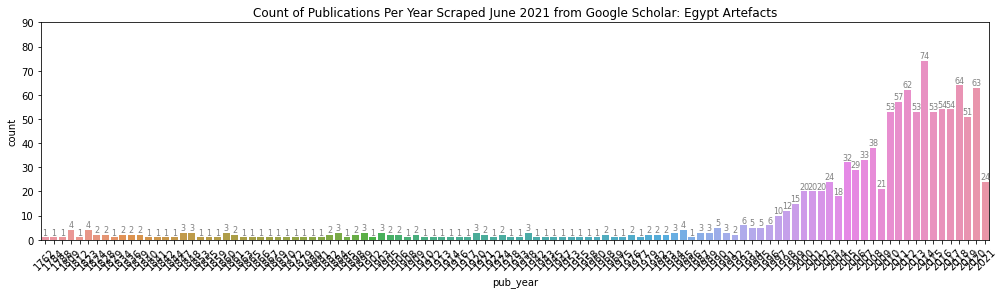

In [219]:
plt.figure(figsize=[17,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=df_groupedby_date, 
             x="pub_year", 
             y="count") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,90) #To make space for the annotations
plt.savefig('../artefacts/ea_gs_pubcount.eps', format='eps')

In [220]:
df_groupedby_date_2016 = df_groupedby_date[df_groupedby_date['pub_year'] > 2015]

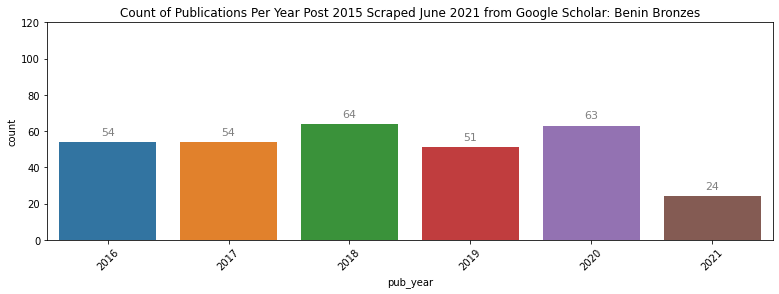

In [221]:
plt.figure(figsize=[13,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Post 2015 Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date_2016, 
             x="pub_year", 
             y="count")
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations
plt.savefig('../artefacts/ea_gs_pubcountpost2015.eps', format='eps')

## 2. Keywords - Network diagram

In [222]:
def get_abstract(x):
    try:
        return ast.literal_eval(x)['abstract']
    except KeyError:
        return ''

In [223]:
df['abstract'] = df['bib'].apply(lambda x: get_abstract(x) )
df_abs = df[df['abstract']!= '']

We lose around 100 publications because they do not have abstracts

In [224]:
df_abs = ct.clean_tweets(df_abs,'abstract','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 9.014319896697998s. Use the [lemma_text] column to perform your analysis/modeling on


In [21]:
df_abs = ct.clean_tweets(df_abs,'abstract','stem_text',
                general_clean=True,lemma=False,stem=True,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 1.9024879932403564s. Use the [stem_text] column to perform your analysis/modeling on


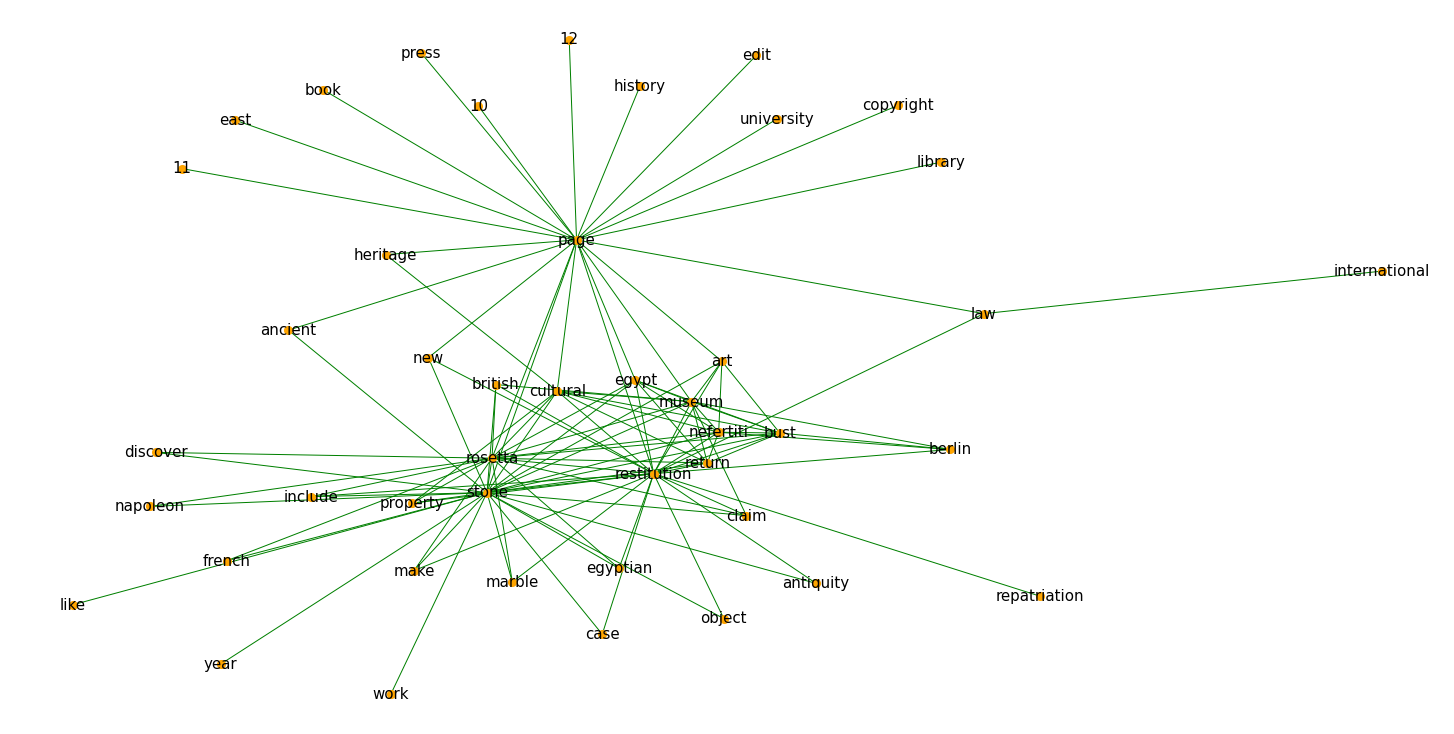

In [141]:
_ = draw_network(df_abs, 'lemma_text', 36, 'ea_abstracts_36') 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

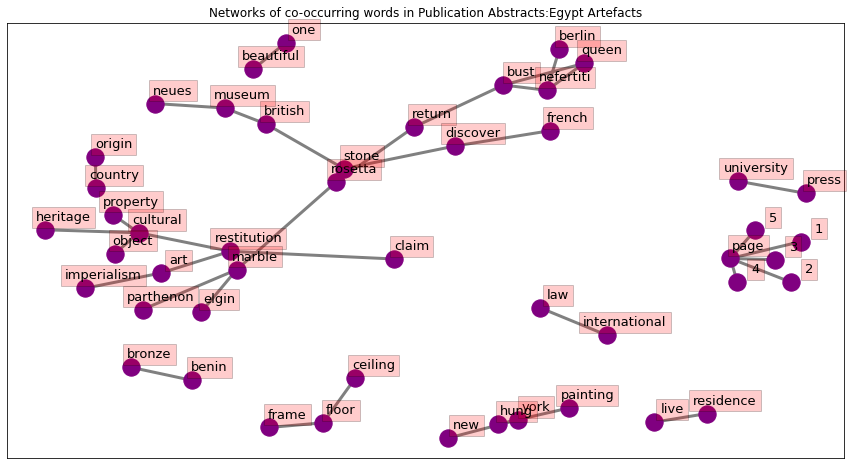

In [144]:
draw_cooccur_network(df_abs, 43,'lemma_text', 'Networks of co-occurring words in Publication Abstracts:Egypt Artefacts')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/matplotlib/backends/backend_ps.py:633: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=LOAD_NO_HINTING)
/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


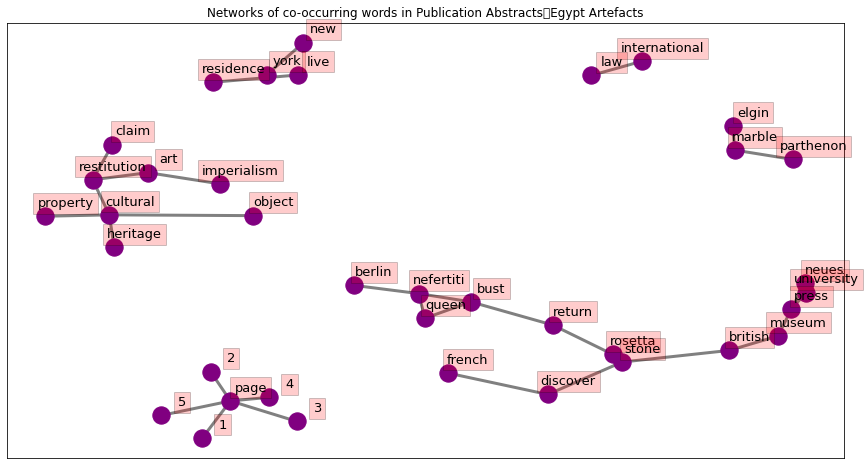

In [145]:
draw_cooccur_network(df_abs, 35,'lemma_text', 'Networks of co-occurring words in Publication Abstracts：Egypt Artefacts')

## 3. Peoples vs citations vs ethnicity - CSV list, network diagram

In [225]:
from ethnicolr import pred_wiki_ln, pred_wiki_name

In [226]:
import unicodedata

In [227]:
def clean_name(name, surname=False):
    if surname == True:
        res = name.split(' ')[1:]
        surname = ' '.join(chars for chars in res)
        if surname == '':
            surname = name.split(' ')[0]
        name = surname
            
    name = name.lower()
    #remove phonetics
    name = ''.join((c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn'))
    return name

### Authors African vs Not

In [228]:
df = pd.read_csv('../data_gc/egypt_publications.csv', index_col=0)

In [229]:
df.shape

(1275, 13)

In [230]:
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])

In [231]:
df['count'] = 1
dummy = df[['author', 'count']]
dummy1 = dummy.set_index('count').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})

In [232]:
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [233]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('count',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [234]:
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

In [236]:
preds.to_csv('ea_publishers.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


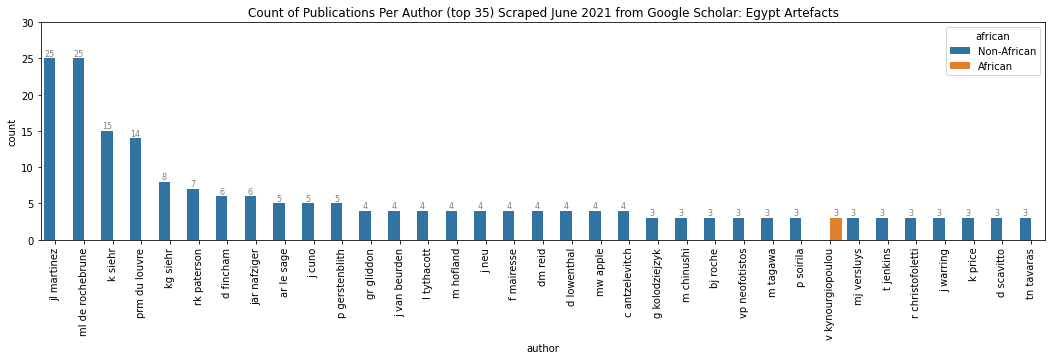

In [156]:
#manual fixes
#fix_list = ['ojaide', 'thebele', 'shyllon', 'sarr']
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=90)
plt.title('Count of Publications Per Author (top 35) Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=preds[0:35], 
             x="author", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,30) #To make space for the annotations
plt.savefig('../artefacts/ea_gs_pubsperauthor.eps', format='eps')

In [214]:
preds

,year,0,surname,has_nums,no_words,no_letters,race,"Asian,GreaterEastAsian,EastAsian","Asian,GreaterEastAsian,Japanese","Asian,IndianSubContinent",...,"GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",african,count
3,2019.0,Thomas Bruce,bruce,0,1,5,"GreaterEuropean,British",0.009158,0.004624,0.007963,...,0.752787,0.012500,0.047139,0.068667,0.011715,0.019151,0.025484,0.013164,Non-African,1
4,2019.0,Cook,cook,0,1,4,"GreaterEuropean,British",0.004843,0.000948,0.001837,...,0.969137,0.000308,0.006024,0.003508,0.001186,0.003277,0.004340,0.000254,Non-African,1
5,2019.0,Hoa,hoa,0,1,3,"GreaterEuropean,British",0.110290,0.060615,0.038575,...,0.335396,0.100884,0.185598,0.022162,0.005525,0.051477,0.016049,0.025526,Non-African,1
6,2019.0,Alice Procter,procter,0,1,7,"GreaterEuropean,British",0.007670,0.005029,0.005509,...,0.762619,0.019880,0.100353,0.049034,0.012131,0.008491,0.015412,0.004496,Non-African,1
7,2019.0,Zahi Hawass,hawass,0,1,6,"GreaterEuropean,British",0.009683,0.016770,0.058464,...,0.303168,0.002065,0.117173,0.008325,0.007856,0.017884,0.024223,0.021261,African,1
8,2019.0,Monika Grütters,grutters,0,1,8,"GreaterEuropean,British",0.025556,0.008055,0.005224,...,0.703279,0.019458,0.047386,0.052464,0.031875,0.021119,0.068892,0.010010,Non-African,1
10,2019.0,Hawass,hawass,0,1,6,"GreaterEuropean,British",0.009683,0.016770,0.058464,...,0.303168,0.002065,0.117173,0.008325,0.007856,0.017884,0.024223,0.021261,African,1
11,2019.0,Emmanuel Macron,macron,0,1,6,"GreaterEuropean,British",0.023244,0.010613,0.002311,...,0.665650,0.005879,0.020877,0.173251,0.003579,0.009419,0.041029,0.002147,Non-African,1
13,2019.0,Macron,macron,0,1,6,"GreaterEuropean,British",0.023244,0.010613,0.002311,...,0.665650,0.005879,0.020877,0.173251,0.003579,0.009419,0.041029,0.002147,Non-African,1
14,2019.0,Sam Nixon,nixon,0,1,5,"GreaterEuropean,British",0.000281,0.002453,0.004207,...,0.981257,0.000507,0.005961,0.001471,0.000118,0.001994,0.001249,0.000135,Non-African,1


In [157]:
half = int(len(preds)/2)
ratio = preds.sort_values('count', ascending = False)[:half].groupby('african').agg('sum').reset_index()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


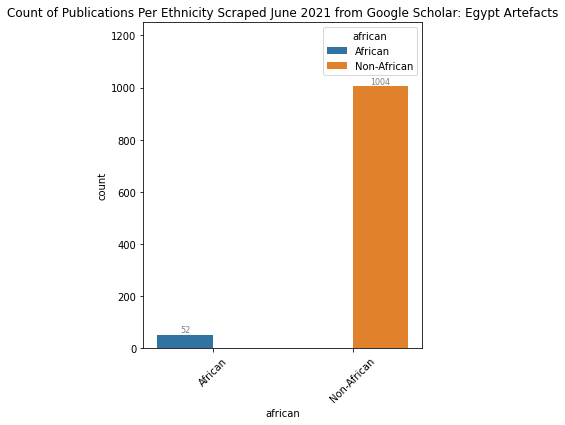

In [158]:
#ratio = preds.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Ethnicity Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,1250) #To make space for the annotations
plt.savefig('../artefacts/ea_gs_pubsperethnicity.eps', format='eps')

Ethnicity over time

In [159]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']
df_not_nan = df_not_nan[df_not_nan['pub_year'].astype(int) > 2015]
year_author = df_not_nan.set_index('pub_year', append=True).author.apply(pd.Series).stack().reset_index(level=[0, 2], drop=True).reset_index()
year_author['surname'] = year_author[0].apply(lambda x: clean_name(x, True))
preds = pred_wiki_ln(year_author, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))
#manual fixes
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
preds['count'] = 1
ratio = preds.groupby(['pub_year','african']).agg('sum').reset_index()

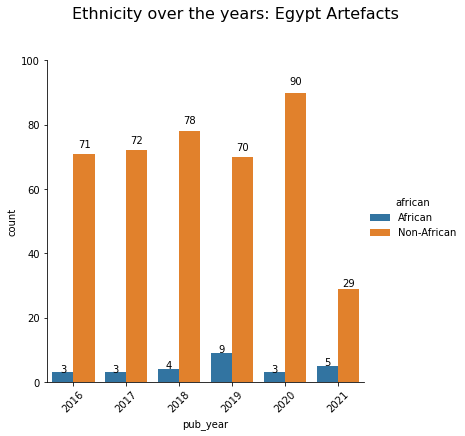

In [160]:
catp = sns.catplot(x = "pub_year",   # x variable name
            y = "count",      # y variable name
            hue = "african",  # group variable name
            data = ratio,     # dataframe to plot
            kind = "bar")

# This will merge columns in order of the chart
vals = ratio[ratio['african'] == 'African']['count'].to_list() + ratio[ratio['african'] == 'Non-African']['count'].to_list()
    
# Add the values on top of each correct bar
i = 0
for idx, p in enumerate(catp.ax.patches):
    height = p.get_height()
    catp.ax.text(p.get_x()+p.get_width()/2.,
            height + height*.03,
            vals[idx],
            ha="center")
_ = catp.ax.set_ylim(0,100) #To make space for the annotations
plt.xticks(rotation=45)
plt.suptitle('Ethnicity over the years: Egypt Artefacts', size=16, y=1.12)
#plt.tight_layout()
plt.savefig('../artefacts/ea_gs_ethnicity_years.eps', format='eps')
plt.show()

### Authors vs citations

These are the publications that have citations and only from 2016. A whole lot less publications from the total collected

In [161]:
df = pd.read_csv('../data_gc/egypt_pub_citations.csv', index_col=0)
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])
df['citing_authors'] = df['citations'].apply(lambda x: [item['author'] for item in ast.literal_eval(x)])
dummy = df[['author', 'num_citations']]

In [162]:
dummy1 = dummy.set_index('num_citations').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [163]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('num_citations',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [164]:
#ethnicity thing needs a specific dev environment
#https://ethnicolr.readthedocs.io/ethnicolr.html
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

In [165]:
#manual fixes
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


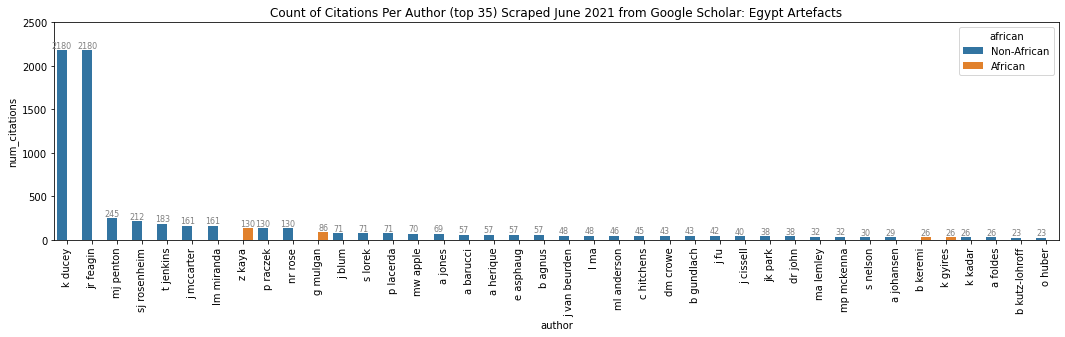

In [166]:
plt.figure(figsize=[18,4])
plt.xticks(rotation=90)
plt.title('Count of Citations Per Author (top 35) Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=preds[0:40], 
             x="author", 
             y="num_citations",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,2500) #To make space for the annotations
plt.savefig('../artefacts/ea_gs_citesperauthor.eps', format='eps')

In [167]:
half = int(len(preds)/2)

In [168]:
ratio = preds.sort_values('num_citations', ascending=False)[:half].groupby('african').agg('sum').reset_index()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


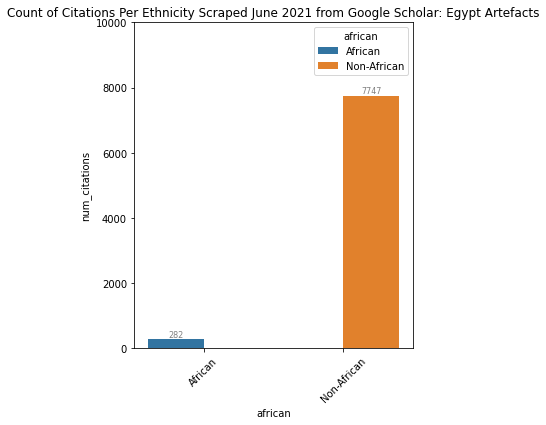

In [169]:
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Citations Per Ethnicity Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=ratio, 
             x="african", 
             y="num_citations",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,10000) #To make space for the annotations
plt.savefig('../artefacts/ea_gs_citesperethnicity.eps', format='eps')

# Media 

In [170]:
import regex

In [171]:
df = pd.read_csv('../data_gc/eg_google_content468_cleaned.csv', index_col=0)
df.shape

(471, 6)

#### Cleaning

Drop pdfs

In [172]:
df = df[~df['link'].str.contains('.pdf')]
df.shape

(415, 6)

Drop nan text

In [173]:
df_text = df[~df['text'].isna()]
df_text['text_len'] = df_text['text'].apply(lambda x: len(x))
df_text.shape

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(391, 7)

Drop strange links

In [174]:
df_text = df_text[~df_text['link'].astype(str).str.contains("�")]
df_text.shape

(388, 7)

Remove strange lemma text things

In [175]:
df_text = df_text[~df_text['lemma_text'].isna()]
df_text.shape

(387, 7)

Remove non relevant articles

In [176]:
# last link mentions nefertiti bust saga but mostly not about nefertiti bust
# these were found looking for the word "executive"
links_to_remove = ['https://investors.rosettastone.com/node/8886/html',
                  'https://www.duhocchina.com/wiki/en/Louvre',
                  'https://www.secret-bases.co.uk/wiki/Louvre',
                  'https://m.imdb.com/name/nm0000232/trivia',
                  'https://www.justice.gov/usao-ndil/pr/former-chicago-man-sentenced-12-years-prison-8-million-investment-fraud-and-15-million',
                  'https://www.alleghenycounty.us/',
                  'https://www.fbi.gov/chicago/press-releases/2010/cg122710.htm',
                  'https://arlisna.org/news/advocacy-public-policy-news-alerts/893-public-policy-committee-news-alert-march-2016'
                  ]
# found using word "comet"
links_to_remove.append('https://eoportal.org/web/eoportal/satellite-missions/content/-/article/rosetta')

#found using the word "ventricular"
links_to_remove.append('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7969788/')


In [177]:
df_text = df_text[~df_text['link'].isin(links_to_remove)]
df_text.shape

(377, 7)

In [178]:
df_text[df_text['text'].str.contains('comet')]

,title,link,text,html_date,lemma_text,stem_text,text_len
1374,"Imperialism, art and restitution / - Berkeley Law",https://lawcat.berkeley.edu/record/437772?ln=en,ch. 1. View from the universal museum / James ...,2006-01-01,ch 1 view universal museum james cuno ch 2 glo...,ch 1 view univers museum jame cuno ch 2 global...,982
2446,réouverture musée paris - Finques Marcel,http://www.finquesmarcel.com/uquo/r%C3%A9ouver...,[68] After Jean-François Champollion translate...,NaN,68 jean françois champollion translate rosetta...,68 jean françoi champollion translat rosetta s...,39547


### 1. Keywords - Network diagram: Pelonomi

The green newtork diagrams are with regards to word similarity based on the texts

In [179]:
text_col = 'lemma_text'

In [180]:
per = int(len(df_text)*0.5)

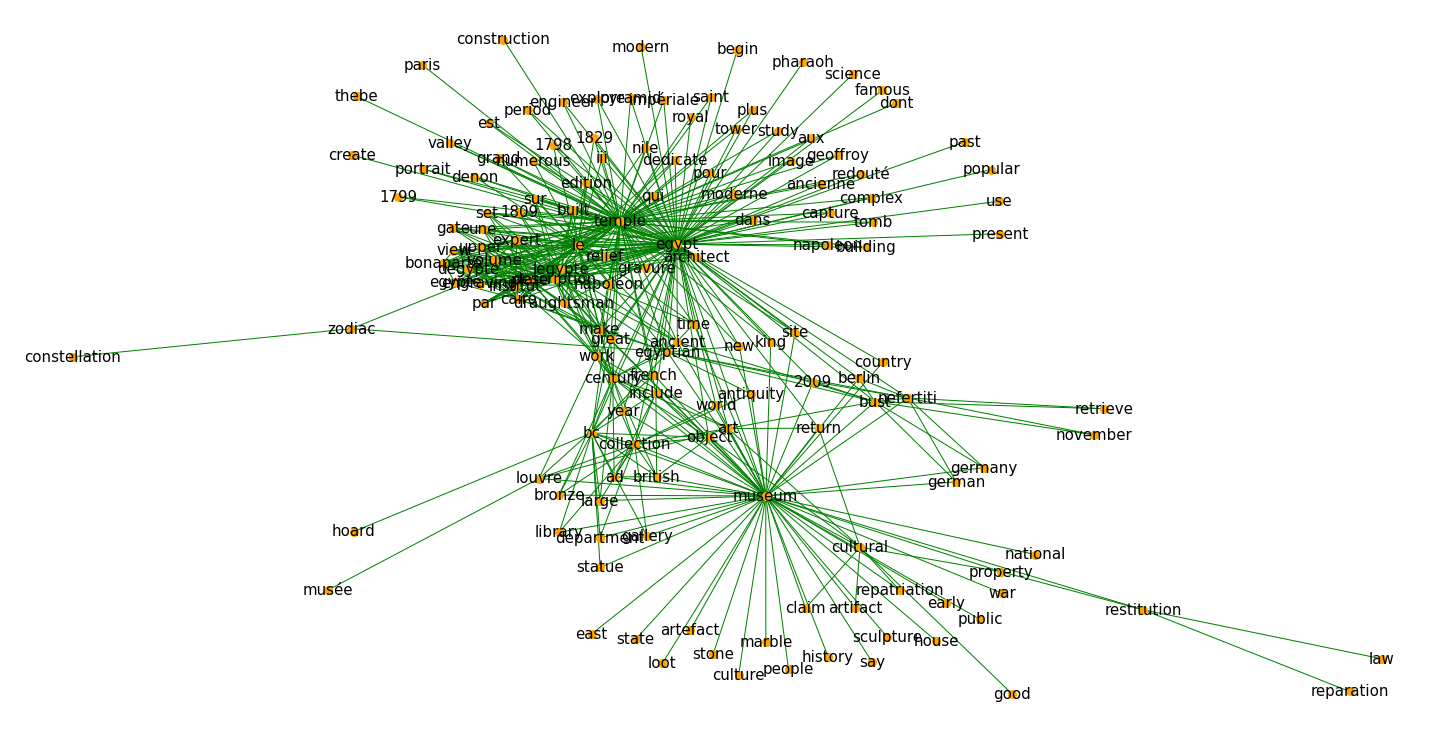

In [181]:
a = draw_network(df_text.sample(per), 'lemma_text', 10000, 'ea_gc_content40000') #20000

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

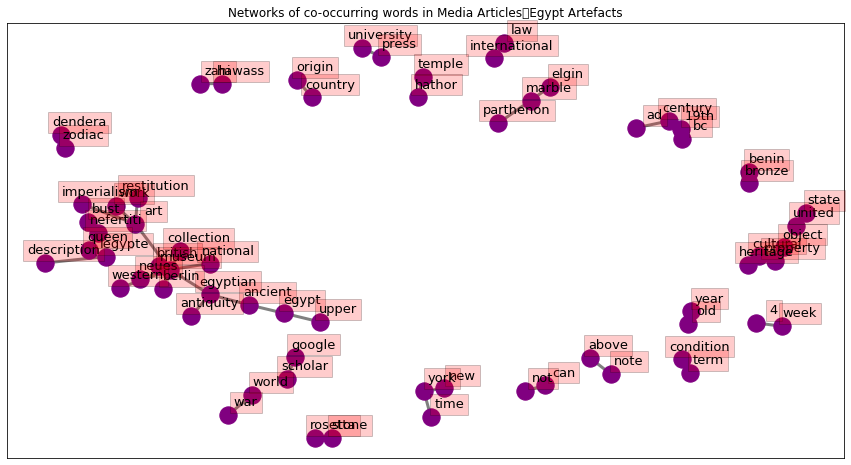

In [182]:
draw_cooccur_network(df_text, 45,'lemma_text', 'Networks of co-occurring words in Media Articles：Egypt Artefacts')

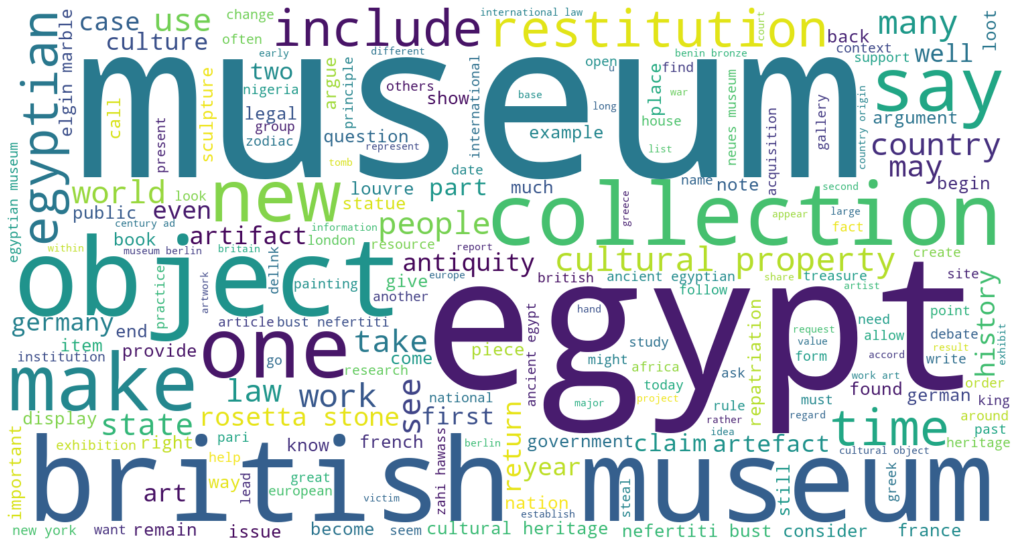

In [183]:
get_wordcloud(df_text, 'lemma_text', 'ea_content_wc')

In [159]:
df_text.to_csv('egypt_google_text_manual_clean.csv')

### 2. Peoples vs mentions vs ethnicity - CSV list, bar chart: Pelonomi

In [ ]:
#this section requires Spacy
#!pip install spacy
#!python -m spacy download en_core_web_sm

#### Get names first

In [184]:
import spacy

In [185]:
from nltk.corpus import stopwords

In [186]:
def NER(text):
    """Takes in a string of text and returns a dataframe of all named entities
    
        Args:
            :param text: string, a string containing entire corpus
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    entities = []
    labels = []
    position_start = []
    position_end = []

    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)

    df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

    return df

In [38]:
#there is a couple of nans in here (8 articles in total) including two Japanese articles hahaha
text = ''.join(x for x in df_text['text'])

In [39]:
len(text)

4018733

In [40]:
stopwords_eng = stopwords.words('english')
tokenized_doc = text.split()
no_stopwords = " ".join([item for item in tokenized_doc if item not in stopwords_eng])  

In [41]:
len(no_stopwords)

3077543

In [35]:
ner_df = NER(no_stopwords[0:1000000])
ner_df2 = NER(no_stopwords[1000000:2000000])
ner_df3 = NER(no_stopwords[2000000:3000000])

In [37]:
ner_df4 = NER(no_stopwords[3000000:4000000])

In [38]:
ner_df5 = NER(no_stopwords[4000000:])

In [46]:
ner = pd.concat([ner_df, ner_df2, ner_df3, ner_df4, ner_df5])
ner['count'] = 1
ner = ner[(ner['Labels'] == 'PERSON')]

In [47]:
ner['Entities'] = ner['Entities'].astype(str)
ner = ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

In [ ]:
exl_list = ['Benin', 'British', 'Museums', 'Rosetta Stone', 'Dendera', 'Nefertiti', 
            'Benin Bronzes', 'Denderah','Egypte', 'Cairo', 'Parthenon', 'ed']
ner = ner[~ner['Entities'].isin(exl_list)]

In [ ]:
ner[['Entities', 'count']].to_csv('data/egypt_media_people_mentions.csv')

I wrote to file here, started the ethnic env then read in the file and continued

In [187]:
import re

In [237]:
ner = pd.read_csv('../data_gc/egypt_media_people_mentions.csv', index_col=0)

In [238]:
ner['surname'] = ner['Entities'].apply(lambda x: clean_name(x, True))

In [239]:
remove_list = ['Benin', 'Twitter', 'Panther', 'Museum', 'Museums', 'Egypte', 'Nefertiti', 'Dendera', 
               'Egypt', 'Stone', 'Cairo', 'Parthenon', 'Giza', 'ed', 'Luxor', 'Ptolemaic', 'Nebamun', 'Greeks',
               'Galerie', 'Optionee','Leo', 'Tutankhamun', 'Lisa' , 'Saqqara', 'Alexandria', 'Moderne', 'Fatimid',
              'Thebes', 'Athens', 'Karnak', 'Ancienne', 'Zodiac', 'Dhabi', 'Amarna']
for item in remove_list:
    ner = ner[~ner['surname'].str.contains(item.lower())]

#### remove non names

In [240]:
ner = ner[~ner['surname'].str.contains("\/")]
ner = ner[~ner['surname'].str.contains("\(")]
ner = ner[~ner['surname'].str.contains("\.")]
ner = ner[~ner['surname'].str.contains("\|")]
ner = ner[~ner['surname'].str.contains("\--")]
ner = ner[~ner['surname'].str.contains("\- ")]
ner = ner[~ner['surname'].str.contains("ii")]
ner = ner[~ner['surname'].str.contains("iv")]
ner['surname'] = ner['surname'].str.replace("'s'", '')
ner['has_nums'] = ner['surname'].apply(lambda x: len(re.findall('\d+', x)))
ner = ner[ner['has_nums'] ==0]
ner['no_words'] = ner['surname'].apply(lambda x: len(x.split()))
ner = ner[ner['no_words'] <=3]
ner['no_letters'] = ner['surname'].apply(lambda x: len(x))
ner = ner[ner['no_letters'] >1]

In [241]:
preds2 = pred_wiki_ln(ner, "surname")

In [242]:
preds2["surname"].replace({"henry merryman": "merryman"}, inplace=True)

In [243]:
preds2 = preds2.groupby('surname').agg('sum').reset_index()

In [244]:
def returncolname(row, colnames):
    col = np.argmax(row.values[2:])
    new_pos = col + 2
                    
    return colnames[new_pos]

In [245]:
preds2 = preds2.drop(['no_words', 'has_nums', 'no_letters'], axis = 1)

In [246]:
preds2['race'] = preds2.apply(lambda x: returncolname(x, preds2.columns), axis=1)

In [247]:
preds2['african'] = preds2['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

In [248]:
preds2[preds2['surname'].str.contains('merryman')]

,surname,count,"Asian,GreaterEastAsian,EastAsian","Asian,GreaterEastAsian,Japanese","Asian,IndianSubContinent","GreaterAfrican,Africans","GreaterAfrican,Muslim","GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",race,african
1843,henry merryman excerpt,1,0.000460,0.002529,0.000931,0.006096,0.005665,0.032225,0.026395,0.032186,0.029247,0.736075,0.009281,0.113556,0.005356,"GreaterEuropean,WestEuropean,Germanic",Non-African
1844,henry merryman find,1,0.002370,0.002482,0.003337,0.002316,0.001287,0.249908,0.040888,0.067565,0.104577,0.333646,0.120544,0.022092,0.048989,"GreaterEuropean,WestEuropean,Germanic",Non-African
2696,merryman,145,0.006123,0.006656,0.008226,0.005503,0.017210,1.981784,0.150696,2.305471,0.182316,0.042636,0.238251,0.050557,0.004571,"GreaterEuropean,Jewish",Non-African
2697,merryman’s,1,0.001965,0.003162,0.001530,0.004372,0.004697,0.085997,0.046017,0.030937,0.309293,0.022007,0.394626,0.065764,0.029633,"GreaterEuropean,WestEuropean,Hispanic",Non-African
3631,see merryman,1,0.002179,0.001796,0.002416,0.000435,0.003203,0.689068,0.009132,0.162108,0.040572,0.005253,0.067178,0.015593,0.001067,"GreaterEuropean,British",Non-African


In [249]:
preds2.sort_values('count', ascending=False)[0:35]

,surname,count,"Asian,GreaterEastAsian,EastAsian","Asian,GreaterEastAsian,Japanese","Asian,IndianSubContinent","GreaterAfrican,Africans","GreaterAfrican,Muslim","GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",race,african
1805,hawass,199,0.096829,0.167699,0.584644,1.387947,2.743331,3.031679,0.020648,1.171731,0.083246,0.078558,0.178841,0.242235,0.212612,"GreaterEuropean,British",Non-African
2696,merryman,145,0.006123,0.006656,0.008226,0.005503,0.017210,1.981784,0.150696,2.305471,0.182316,0.042636,0.238251,0.050557,0.004571,"GreaterEuropean,Jewish",Non-African
527,borchardt,92,0.078993,0.034472,0.006161,0.008261,0.013614,0.876569,0.067712,0.187308,0.583883,0.375988,0.469257,0.088216,0.209566,"GreaterEuropean,British",Non-African
2523,macron,90,0.069733,0.031838,0.006933,0.111720,0.014282,1.996950,0.017637,0.062631,0.519752,0.010736,0.028257,0.123088,0.006442,"GreaterEuropean,British",Non-African
1896,hitler,63,0.016272,0.014808,0.023424,0.017424,0.010534,2.112366,0.031196,0.513809,0.087361,0.035572,0.106943,0.018070,0.012221,"GreaterEuropean,British",Non-African
2351,laroze,59,0.002406,0.002858,0.001013,0.057274,0.040784,0.019240,0.073091,0.071033,0.629827,0.006235,0.068055,0.027455,0.000728,"GreaterEuropean,WestEuropean,French",Non-African
1131,denon,47,0.011782,0.012619,0.363742,0.055014,0.037744,1.291609,0.131008,0.424667,2.429282,0.022705,0.054288,0.148475,0.017064,"GreaterEuropean,WestEuropean,French",Non-African
517,bonaparte,42,0.003201,0.001305,0.013014,0.003924,0.002501,0.102238,0.002888,0.017654,4.727966,0.012040,0.265164,2.829911,0.018193,"GreaterEuropean,WestEuropean,French",Non-African
4219,wildung,41,3.168762,0.027897,0.008982,0.025509,0.012946,1.321556,0.031561,0.011853,0.054328,0.006714,0.141045,0.005613,0.183234,"Asian,GreaterEastAsian,EastAsian",Non-African
3707,simon,36,0.041472,0.046059,0.043285,0.217244,0.046275,0.393380,0.152578,1.961744,1.814517,0.005859,0.106219,0.147318,0.024051,"GreaterEuropean,Jewish",Non-African


In [250]:
#manual fixes
for name in fix_list:
    preds2.loc[preds2['surname']==name, 'african'] = 'African'

In [254]:
preds2.sort_values('count', ascending = False).reset_index().drop(['index'], axis =1).to_csv('ea_mentions.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


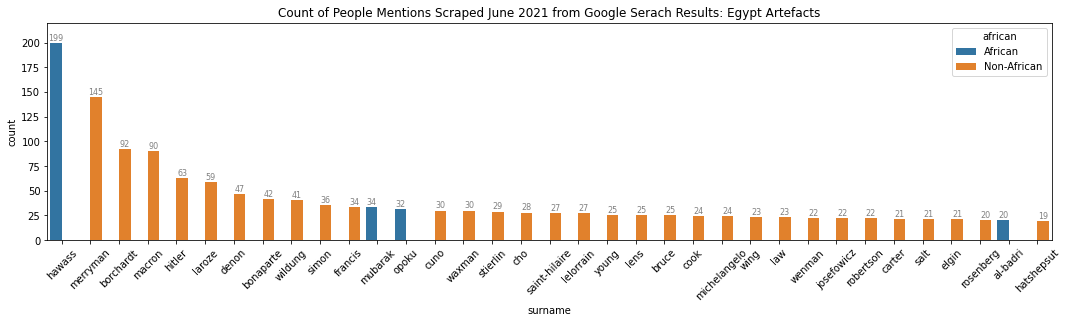

In [202]:
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Scraped June 2021 from Google Serach Results: Egypt Artefacts')
g = sns.barplot(data=preds2.sort_values('count', ascending=False)[0:35], 
             x="surname", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,220) #To make space for the annotations
plt.savefig('../artefacts/ea_gc_mentionsperperson.eps', format='eps')

In [203]:
half = int(len(preds2)/2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


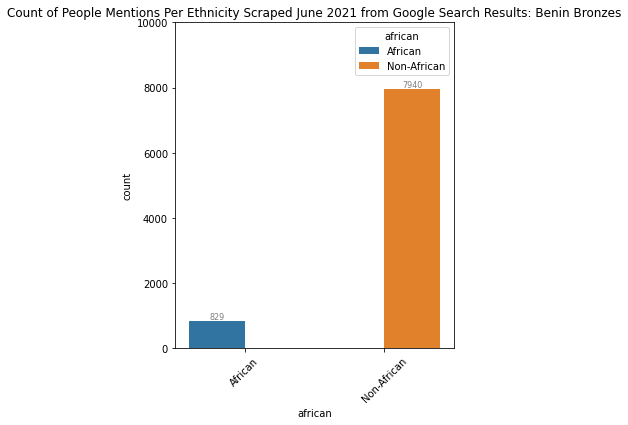

In [204]:
ratio = preds2.sort_values('count', ascending = False)[:half].groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Per Ethnicity Scraped June 2021 from Google Search Results: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,10000) #To make space for the annotations
plt.savefig('../artefacts/ea_gc_mentionsperethnicity.eps', format='eps')

In [205]:
def ner_article(text):
    """Takes in a string of text and returns persons mentioned
    
        Args:
            :param text: string, a string containing entire corpus
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    entities = []

    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            entities.append(str(ent))

    return entities

In [206]:
df = df[~df['text'].isna()]
df['persons'] = df['text'].apply(lambda x: ner_article(x))
# filter by single year
df['html_date'] = df['html_date'].astype('datetime64[ns]')
df_filtered = df[df['html_date'].dt.strftime('%Y') > '2015']

In [207]:
df_filtered['year'] = pd.DatetimeIndex(df_filtered['html_date']).year

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [208]:
year_author = df_filtered.set_index('year', append=True).persons.apply(pd.Series).stack().reset_index(level=[0, 2], drop=True).reset_index()
for item in remove_list:
    year_author = year_author[~year_author[0].str.contains(item)]
year_author['surname'] = year_author[0].apply(lambda x: clean_name(x, True))

In [209]:
year_author = year_author[~year_author['surname'].str.contains("\/")]
year_author = year_author[~year_author['surname'].str.contains("\(")]
year_author = year_author[~year_author['surname'].str.contains("\.")]
year_author = year_author[~year_author['surname'].str.contains("\|")]
year_author = year_author[~year_author['surname'].str.contains("\--")]
year_author = year_author[~year_author['surname'].str.contains("\- ")]
year_author = year_author[~year_author['surname'].str.contains("ii")]
year_author = year_author[~year_author['surname'].str.contains("iv")]
year_author['surname'] = year_author['surname'].str.replace("'s'", '')
year_author['has_nums'] = year_author['surname'].apply(lambda x: len(re.findall('\d+', x)))
year_author = year_author[year_author['has_nums'] ==0]
year_author['no_words'] = year_author['surname'].apply(lambda x: len(x.split()))
year_author = year_author[year_author['no_words'] <=3]
year_author['no_letters'] = year_author['surname'].apply(lambda x: len(x))
year_author = year_author[year_author['no_letters'] >1]

In [210]:
remove_list = ['Benin', 'Twitter', 'Panther', 'Museum', 'Museums', 'Egypte', 'Nefertiti', 'Dendera', 
               'Egypt', 'Stone', 'Cairo', 'Parthenon', 'Giza', 'ed', 'Luxor', 'Ptolemaic', 'Nebamun', 'Greeks',
               'Galerie', 'Optionee','Leo', 'Tutankhamun', 'Lisa' , 'Saqqara', 'Alexandria', 'Moderne', 'Fatimid',
              'Thebes', 'Athens', 'Karnak', 'Ancienne', 'Zodiac', 'Dhabi', 'Amarna']
for item in remove_list:
    year_author = year_author[~year_author['surname'].str.contains(item.lower())]

In [211]:
preds = pred_wiki_ln(year_author, "surname")
half = int(len(preds)/2)
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))
#manual fixes
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
preds['count'] = 1
ratio = preds.sort_values('count', ascending = False)[half:].groupby(['year','african']).agg('sum').reset_index()

In [212]:
year_author

,year,0,surname,has_nums,no_words,no_letters,race
3,2019.0,Thomas Bruce,bruce,0,1,5,"GreaterEuropean,British"
4,2019.0,Cook,cook,0,1,4,"GreaterEuropean,British"
5,2019.0,Hoa,hoa,0,1,3,"GreaterEuropean,British"
6,2019.0,Alice Procter,procter,0,1,7,"GreaterEuropean,British"
7,2019.0,Zahi Hawass,hawass,0,1,6,"GreaterEuropean,British"
8,2019.0,Monika Grütters,grutters,0,1,8,"GreaterEuropean,British"
10,2019.0,Hawass,hawass,0,1,6,"GreaterEuropean,British"
11,2019.0,Emmanuel Macron,macron,0,1,6,"GreaterEuropean,British"
13,2019.0,Macron,macron,0,1,6,"GreaterEuropean,British"
14,2019.0,Sam Nixon,nixon,0,1,5,"GreaterEuropean,British"


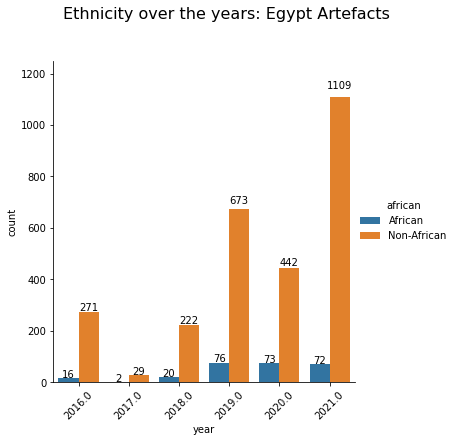

In [213]:
catp = sns.catplot(x = "year",   # x variable name
            y = "count",      # y variable name
            hue = "african",  # group variable name
            data = ratio,     # dataframe to plot
            kind = "bar")

# This will merge columns in order of the chart
vals = ratio[ratio['african'] == 'African']['count'].to_list() + ratio[ratio['african'] == 'Non-African']['count'].to_list()
    
# Add the values on top of each correct bar
i = 0
for idx, p in enumerate(catp.ax.patches):
    height = p.get_height()
    catp.ax.text(p.get_x()+p.get_width()/2.,
            height + height*.03,
            vals[idx],
            ha="center")
_ = catp.ax.set_ylim(0,1250) #To make space for the annotations
plt.xticks(rotation=45)
plt.savefig('../artefacts/ea_gc_mentionsperethnicity.eps', format='eps')
plt.suptitle('Ethnicity over the years: Egypt Artefacts', size=16, y=1.12)
plt.show()

TODO: need to fix this because there are some times where only the surname is mentioned, need to group by on that before getting the ethnicity to get a proper representation of the numbers